In [4]:
import sys, os
if os.path.exists("/home/cb2714/wwa/wwa.py"):
     sys.path.append('/home/cb2714/wwa/')
else:
     sys.path.append('/rds/general/user/cb2714/home/wwa/')
from wwa import *

xn, xx, yn, yx = [125,146,30,46]  # larger region for data retrieval
xn, xx, yn, yx = [125,133,30,40]  # smaller region for plotting

mapproj = cartopy.crs.PlateCarree()

In [ ]:
sf_korea = gpd.read_file("sf_korea")
sf_ekorea = gpd.read_file("sf_ekorea")
sf_kyushu = gpd.read_file("sf_kyushu")

# 1.1 - HDWI map & 5-day accumulation

In [ ]:
hdwi = xr.open_dataset("data/era5land/hdwi-from-vpdmax_era5land_195001-202503.nc").hdwi.rolling(time = 5).mean()
rm = regionmask.mask_geopandas(sf_korea, hdwi.longitude, hdwi.latitude)
ts = hdwi.where(rm == 0, drop = True).mean(["latitude", "longitude"])
ts = ts.assign_coords(offset_time = ("time", ts.time.shift(time = 0).data))

ev_date = ts.groupby("time.month")[3].idxmax()
ev = hdwi.sel(time = ev_date)

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

px = pd.read_csv("data/modis_conf-80.csv", index_col = "acq_date", parse_dates = ["acq_date"])
px_m = px.loc[slice("2025-03-22", "2025-03-26")]

In [132]:
sites = pd.DataFrame.from_dict({s : get_latlon(s) for s in ["Uiseong", " Sancheon"]}).transpose()

/var/tmp/pbs.1005679.pbs/ipykernel_993511/1902817951.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  map_ax =  plt.subplot(121, projection = mapproj, extent = (xn,xx,yn,yx))


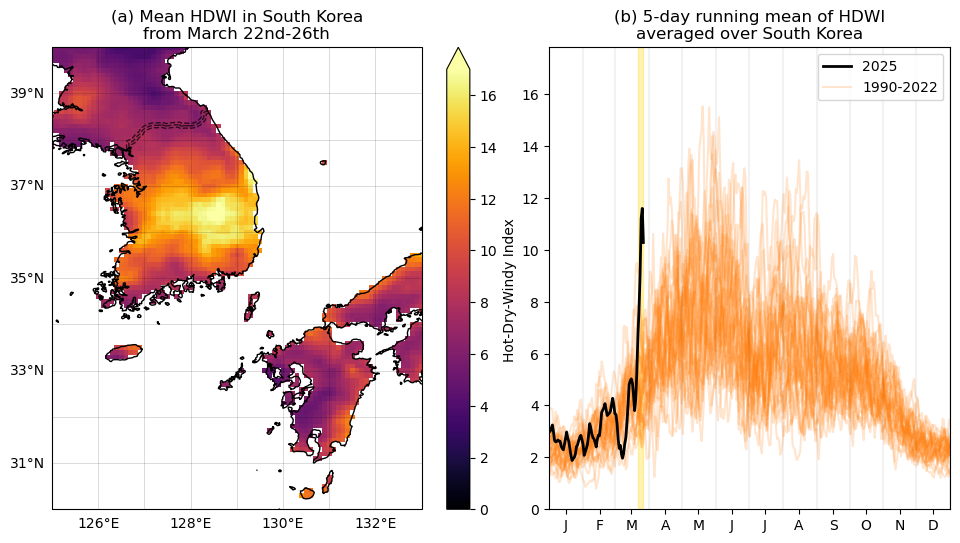

In [134]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,6), dpi = 100, gridspec_kw = {"width_ratios" : [1.25,1]})
plt.subplots_adjust(wspace = 0.06)

map_ax =  plt.subplot(121, projection = mapproj, extent = (xn,xx,yn,yx))
ev.plot(ax = map_ax, vmin = 0, vmax = 17, cmap = "inferno", cbar_kwargs = {"label" : "Hot-Dry-Windy Index", "location" : "right", "pad" : 0.05, "shrink" : 1})
# map_ax.scatter(px_m.longitude, px_m.latitude, color = "k", marker = ".")
# map_ax.scatter(sites.lon, sites.lat, color = "darkred", marker = "x")

map_ax.gridlines(crs = mapproj, linewidth = 0.5, color = 'black', alpha = 0.2, xlocs = range(125,134), ylocs = range(30,42))
map_ax.gridlines(crs = mapproj, linewidth = 0.5, color = 'black', draw_labels = ["left", "bottom"], alpha = 0, xlocs = range(124,134,2), ylocs = range(31,42,2))

map_ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
map_ax.coastlines()
map_ax.set_title("(a) Mean HDWI in South Korea\nfrom March 22nd-26th")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ts_ax =  plt.subplot(122)

y = 2025; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ts_ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2025", lw = 2, zorder = 99)
for y in range(1990,2021):
    ts_y = ts.sel(time = ts.offset_time.dt.year == y)
    ts_ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:orange", alpha = 0.2, label = "_years")
    
# ts_ax.plot(ts.sel(time = slice("1990", "2021")).groupby("time.dayofyear").mean(), color = "darkred")
ts_ax.set_xticks(labelticks)
ts_ax.set_xticklabels(labels)
[ts_ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]

ts_ax.legend(["2025", "1990-2022"])
ylim = ts_ax.get_ylim()
d_start = ts.sel(time = "2025-03-22").time.dt.dayofyear.values
ts_ax.add_patch(Rectangle((d_start, 0), 5, ylim[1]+20, color = "gold", alpha = 0.3))
ts_ax.set_ylim(0,17.8)
ts_ax.margins(x = 0)

ts_ax.set_ylabel("")
ts_ax.set_title("(b) 5-day running mean of HDWI\naveraged over South Korea")
plt.savefig("fig/fig1-1_event-map-hdwi.png")

# 1.2 - precip

In [164]:
from xclim.indices.stats import fit
from scipy.stats import norm, gamma

pr = xr.open_dataset("data/era5land/pr-monthly_era5land_195001-202503.nc").pr
pr_fm = pr.sel(time = pr.time.dt.month.isin([2,3])).resample(time = "AS-FEB").sum()

pr_clim = pr_fm.sel(time = slice("1990","2020")).mean("time")
relanom = ((pr_fm.sel(time = "2025", drop = True) - pr_clim) / pr_clim * 100)

ts = xr.open_dataset("daily-ts/pr_era5_195001-202503_kr.nc").pr
ts = ts.assign_coords(offset_time = ("time", ts.time.shift(time = 181).data))

days = pd.date_range(start = "2020-07-01", end = "2021-07-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

/var/tmp/pbs.1005679.pbs/ipykernel_993511/62799673.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  map_ax =  plt.subplot(121, projection = mapproj, extent = (xn,xx,yn,yx))


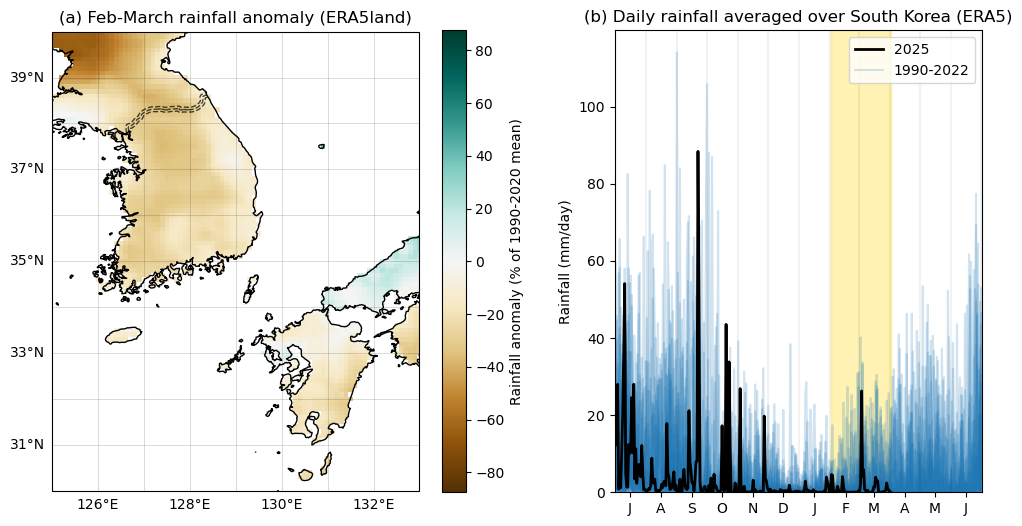

In [168]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,6), dpi = 100, gridspec_kw = {"width_ratios" : [1.25,1]})
plt.subplots_adjust(wspace = 0.25)

map_ax =  plt.subplot(121, projection = mapproj, extent = (xn,xx,yn,yx))
relanom.plot(ax = map_ax, cmap = "BrBG", cbar_kwargs = {"label" : "Rainfall anomaly (% of 1990-2020 mean)", "location" : "right", "pad" : 0.05, "shrink" : 1})

map_ax.gridlines(crs = mapproj, linewidth = 0.5, color = 'black', alpha = 0.2, xlocs = range(125,134), ylocs = range(30,42))
map_ax.gridlines(crs = mapproj, linewidth = 0.5, color = 'black', draw_labels = ["left", "bottom"], alpha = 0, xlocs = range(124,134,2), ylocs = range(31,42,2))

map_ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
map_ax.coastlines()
map_ax.set_title("(a) Feb-March rainfall anomaly (ERA5land)")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ts_ax =  plt.subplot(122)

y = 2024; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ts_ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2025", lw = 2, zorder = 99)
for y in range(1990,2021):
    ts_y = ts.sel(time = ts.offset_time.dt.year == y)
    ts_ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.2, label = "_years")
    
ts_ax.set_xticks(labelticks)
ts_ax.set_xticklabels(labels)
[ts_ax.axvline(x, color = "k", alpha = 0.05) for x in range(366) if (days[x].day) == 1]

ts_ax.legend(["2025", "1990-2022"])
ylim = ts_ax.get_ylim()
d_start = ts.sel(time = "2025-01-31").offset_time.dt.dayofyear.values
ts_ax.add_patch(Rectangle((d_start, 0), 59, ylim[1]+20, color = "gold", alpha = 0.3))
ts_ax.set_ylim(0,ylim[1])
ts_ax.margins(x = 0)

ts_ax.set_ylabel("Rainfall (mm/day)")
ts_ax.set_title("(b) Daily rainfall averaged over South Korea (ERA5)")
plt.savefig("fig/fig1-2_event-map-pr-fm.png")

# 3.2 SC of components of the HDWI

In [4]:
vpd = xr.open_dataset("daily-ts/vpdmax_era5land_195001-202503_kr.nc").vpdmax
sfcWindmax = xr.open_dataset("daily-ts/sfcWindmax_era5land_195001-202503_kr.nc").sfcWindmax
tasmax = xr.open_dataset("daily-ts/tasmax_era5land_195001-202503_kr.nc").tasmax
hursmin = xr.open_dataset("daily-ts/hursmin_era5land_195001-202503_kr.nc").hursmin

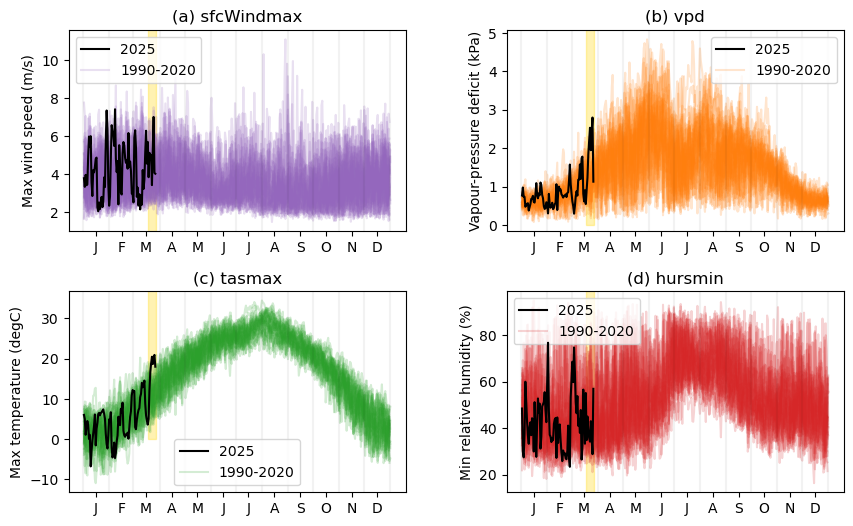

In [11]:
nc = 2; nr = 2
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*5, nr*3), dpi = 100)
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

varbls = ["sfcWindmax", "vpd", "tasmax", "hursmin"]
colours = ["tab:purple", "tab:orange", "tab:green", "tab:red"]
ylabs = ["Max wind speed (m/s)", "Vapour-pressure deficit (kPa)", "Max temperature (degC)", "Min relative humidity (%)"]

for i in range(len(varbls)):
    ax = axs.flatten()[i]
    varnm = varbls[i]
    
    ts = eval(varnm)
    ts = ts.assign_coords(offset_time = ("time", ts.time.shift(time = 0).data)) # shift time for offset axes

    y = 2025; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2025", zorder = 99)
    
    for y in range(1990,2020):
        ts_y = ts.sel(time = ts.offset_time.dt.year == y)
        ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = colours[i], alpha = 0.2, label = "_years")
    
    ax.set_title("("+"abcd"[i]+") "+varnm)
    ax.set_ylabel(ylabs[i])
    
    ax.legend(["2025", "1990-2020"])
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]
    
    ylim = ax.get_ylim()
    ax.add_patch(Rectangle((77, 0), 10, ylim[1]+10, color = "gold", alpha = 0.3))
    ax.set_ylim(ylim)
    
# plt.suptitle("Seasonal cycles of HDWI & component variables averaged over Korea (ERA5-land)", fontweight = "bold", y = 1.025)
plt.savefig("fig/fig3-2_sc-and-2025.png")

# 3.4 Stations vs nearest gridpoint

In [10]:
fl = sorted(glob.glob("data/stations/*.csv"))
fl = [fnm for fnm in fl if not int(fnm.split("_")[1]) in [115,271]]
stn_meta = pd.read_csv("station-metadata.csv", index_col = 0)
stn_meta.loc[130, "lon"] = stn_meta.loc[130, "lon"]-0.1 # move Uljin one grid cell to the west so it's no longer in the sea

In [6]:
varnm = "pr"
nc = 3; nr = int(np.ceil(len(fl)/nc))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

long_varnm = {"hdwi" : "hdwi-from-vpdmax", "tasmax" : "tasmax", "sfcWindmax" : "sfcWindmax", "hursmin" : "hursmin", "pr" : "pr-monthly", "vpd" : "vpdmax"}[varnm]
ttl_varnm = {"hdwi" : "HDWI5x", "tasmax" : "Tx5x", "sfcWindmax" : "sfcWindmax5x", "hursmin" : "hursmin5n", "pr" : "pr-fm", "vpd" : "vpd"}[varnm]

ds = xr.open_dataset("data/era5land/"+long_varnm+"_era5land_195001-202503.nc")
ds = ds[list(ds.data_vars)[0]]

if varnm == "hursmin" : 
    ds = ds.rolling(time = 5).mean().groupby("time.month")[3].resample(time = "AS-MAR").min().dropna("time", "all")
elif varnm == "pr" : 
    ds = convert_units_to(ds, "mm/month").sel(time = ds.time.dt.month.isin([2,3])).resample(time = "AS-MAR").sum().dropna("time", "all")
    ds = ds.where(ds > 0)
else: 
    ds = ds.rolling(time = 5).mean().groupby("time.month")[3].resample(time = "AS-MAR").max().dropna("time", "all")

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 4, nr * 3), dpi = 100, sharex = True)
plt.subplots_adjust(hspace = 0.3)

for i in range(len(fl)):
    fnm = fl[i]
    ax = axs.flatten()[i]
    
    stn_data = stn_meta.loc[int(fnm.split("_")[1])]
    
    ts = pd.read_csv(fl[i], index_col = "date", parse_dates = ["date"])
    if varnm == "hursmin" : 
        ts5x = ts[varnm].rolling(5).mean().loc[ts.index.month.isin([3])].resample("AS-MAR").min().dropna(axis = 0, how = "any")
    elif varnm == "pr" : 
        ts5x = ts[varnm].loc[ts.index.month.isin([2,3])].resample("AS-MAR").sum().dropna(axis = 0, how = "any")
    else: 
        ts5x = ts[varnm].rolling(5).mean().loc[ts.index.month.isin([3])].resample("AS-MAR").max().dropna(axis = 0, how = "any")
    
    era5 = ds.sel(longitude = stn_data.lon, latitude = stn_data.lat, method = "nearest")
    era5 = era5.assign_coords(time = era5.time.dt.year).rename(time = "year")
    
    ax.plot(ts5x.index.year, ts5x, color = "k")
    ax.plot(era5.year, era5, color = "tab:blue")
    ax.plot(ts5x.index.year, lowess(ts5x.values, ts5x.index.year.values)[:,1], ls = "--", color = "k", alpha= 0.5)
    if not np.isnan(era5).all(): ax.plot(era5.year, lowess(era5.values, era5.year.values)[:,1], ls = "--", color = "tab:blue", alpha= 0.5)
    ax.set_title(stn_data.stn_name)
    
    ax.legend(["Station", "ERA5land"])
    
for i in range(len(fl), nc*nr): axs.flatten()[i].set_axis_off()
# plt.suptitle("Stations vs nearest ERA5land grid cell - "+ttl_varnm, fontweight = "bold", y = 0.95)
plt.savefig("fig/stn-vs-era5land_"+varnm+".png")

## Check missingness

In [90]:
ds = xr.open_dataset("data/era5_tp_daily_extended_125-146E_30-46N.nc").tp

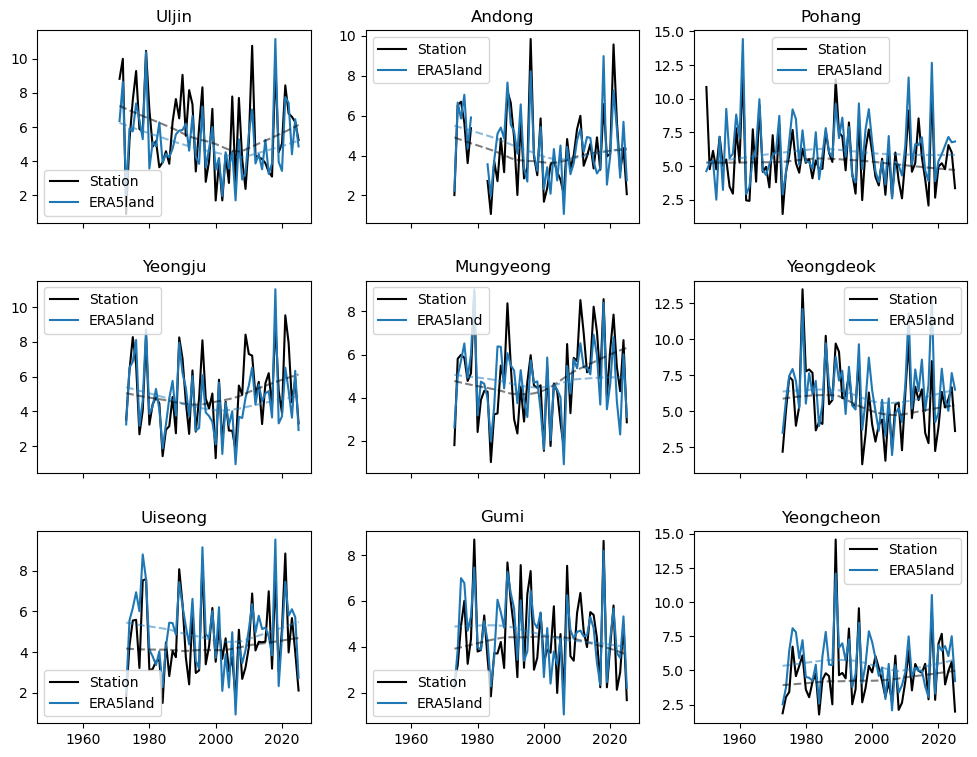

In [91]:
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 4, nr * 3), dpi = 100, sharex = True)
plt.subplots_adjust(hspace = 0.3)

for i in range(len(fl)):
    fnm = fl[i]
    ax = axs.flatten()[i]
    
    stn_data = stn_meta.loc[int(fnm.split("_")[1])]
    
    ts = pd.read_csv(fl[i], index_col = "date", parse_dates = ["date"])[["pr"]]

        

    era5 = ds.sel(lon = stn_data.lon, lat = stn_data.lat, method = "nearest").reset_coords(drop = True)
    
    # select only dates when there is rain in the station record
    df = pd.merge(ts, era5.to_dataframe(), left_index = True, right_index = True)
    df = df.loc[~np.isnan(df.pr)]
    df = df.loc[df.index.month.isin([2,3])].resample("AS-FEB").mean()
    
    if i in [3,4]: df = df.iloc[1:,:]

    ax.plot(df.index.year, df.pr, color = "k")
    ax.plot(df.index.year, df.tp, color = "tab:blue")
    df = df.dropna(axis = 0, how = "any")
    ax.plot(df.index.year, lowess(df.pr.values, df.index.year.values)[:,1], ls = "--", color = "k", alpha= 0.5)
    ax.plot(df.index.year, lowess(df.tp.values, df.index.year.values)[:,1], ls = "--", color = "tab:blue", alpha= 0.5)
    ax.set_title(stn_data.stn_name)
    
    ax.legend(["Station", "ERA5land"])
    
# plt.suptitle("Stations vs nearest ERA5land grid cell - "+ttl_varnm, fontweight = "bold", y = 0.95)
plt.savefig("fig/stn-vs-era5land_daily-pr-rate.png")

# A1.1 HDWI from vpdmax vs hursmin

In [92]:
fig, ax = plt.subplots(ncols = 1, figsize = (6, 4), dpi = 100)
   
fl = [fnm for fnm in sorted(glob.glob("daily-ts/vpd*kr.nc")) if not "monthly" in fnm and not "dew" in fnm]

for fnm in fl:
    ts = xr.open_dataset(fnm)
    ts = ts[list(ts.data_vars)[0]]
    
    varnm = fnm.split("/")[-1].split("_")[0]
    col = {"vpdmax" : "k", "vpd-from-hursmin" : "tab:blue", "vpd-from-dewmax" : "tab:orange", "vpd-from-monthly" : "tab:green",
           "hdwi-from-vpdmax" : "k", "hdwi-from-hursmin" : "tab:blue", "hdwi-from-dewmax" : "tab:orange", "hdwi-from-monthly" : "tab:green"}[varnm]
    
    vpd5x = ts.rolling(time = 5).mean().groupby("time.month")[3].resample(time = "AS-MAR").max().dropna("time", "any")
    vpd5x = vpd5x.assign_coords(time = vpd5x.time.dt.year).rename(time = "year")
    
    vpd5x.plot(ax = ax, drawstyle = "steps-mid", label = varnm, color = col)
    ax.plot(vpd5x.year.values, lowess(vpd5x.values, vpd5x.year.values)[:,1], color = col, alpha = 0.5, lty = "--"")
    
ax.legend()
ax.set_xlabel("")
plt.savefig("fig/app_compare-vpd-calculations.png")

SyntaxError: unterminated string literal (detected at line 17) (1791658434.py, line 17)

# Synthesis

In [75]:
def synth_plot(df, ax = None, logged = False, split_uw = False):
    
    # set split_uw = True to plot the unweighted mean of obs and models on its own line
    if not ax: fig, ax = plt.subplots(dpi = 100)
    
    gcols = {"obs" : "blue", 
             "obs_synth" : "blue", 
             "models" : "red", 
             "model_synth" : "red",
             "synth" : "magenta"}
    
    ylabels = df.model.to_list()
    
    ax.grid(axis = "x", which = "major", color = "k", alpha = 0.1)
    
    if logged:
        ax.set_xscale('log')
        ax.axvline(1, ls = "--", color = "k", zorder = -99)
    else:
        ax.axvline(0, ls = "--", color = "k", zorder = -99)
    
    for k in range(len(df)):

        r = df.iloc[k]
        ax.add_patch(Rectangle((r.lower,-k-0.4), r.upper - r.lower, 0.8, facecolor = gcols[r.name], alpha = 0.5 + 0.5*("synth" in r.name)))
        ax.plot(r.est, -k, color = "k", marker = "v")
        
        if not (split_uw and df.index[k] == "synth"): 
            ax.add_patch(Rectangle((r.l_wb,-k-0.4), r.u_wb - r.l_wb, 0.8, edgecolor = "k", facecolor = "none", lw = 1.5))
        else:
            k = k+1
            ax.add_patch(Rectangle((r.l_wb,-k-0.4), r.u_wb - r.l_wb, 0.8, edgecolor = "k", facecolor = "none", lw = 1.5))
            if logged:
                uw_mean = np.exp((np.log(df.loc["obs_synth", "est"]) + np.log(df.loc["model_synth", "est"])) / 2)
            else:
                uw_mean = (df.loc["obs_synth", "est"] + df.loc["model_synth", "est"]) / 2
            ax.plot(uw_mean, -k, color = "k", marker = "v")
            ylabels = ylabels + ["unweighted mean"]

    ax.set_yticks(range(0, -len(ylabels), -1))
    ax.set_yticklabels(ylabels)

In [82]:
varnm = "tx5x"

In [85]:
if varnm in ["tx5x"]:
    dI = "dI-abs"
else:
    dI = "dI-rel"
    
dI_attr, PR_attr = [pd.read_csv("synth/synth_"+varnm+"_kr_"+x+"_attr.csv") for x in [dI, "PR"]]
dI_proj, PR_proj = [pd.read_csv("synth/synth_"+varnm+"_kr_"+x+"_proj.csv") for x in [dI, "PR"]]

di_lim = {"hdwi" : (-50,100), "tx5x" : (-100, 200), "pr-fm" : (-100, 200), }[varnm]

pr_lim = {"hdwi" : (-50,100), "tx5x" : (-100, 200), "pr-fm" : (-100, 200), }[varnm]

In [88]:
dI_attr

,group,model,est,lower,upper,l_wb,u_wb
0,obs,ERA5land**,3.700185,1.836627,5.495883,1.836627,5.495883
1,obs_synth,Observations,3.700185,1.836627,5.495883,NaN,NaN
2,models,AWI-CM3-25km**,2.028612,1.077071,2.857205,1.040104,2.899408
3,models,cmip6_CanESM5_r1i1p1f1*,1.686056,0.984518,2.395230,0.935141,2.444110
4,models,cmip6_CNRM-CM6-1_r1i1p1f2,1.003552,0.073689,2.019887,0.035893,2.054578
5,models,cmip6_EC-Earth3_r1i1p1f1,0.756656,0.134784,1.429484,0.079571,1.480821
6,models,cmip6_EC-Earth3-CC_r1i1p1f1*,1.048576,0.570927,1.570520,0.500975,1.635213
7,models,cmip6_EC-Earth3-Veg_r1i1p1f1*,0.817037,0.190377,1.498719,0.135553,1.549436
8,models,cmip6_EC-Earth3-Veg-LR_r1i1p1f1,0.239183,-0.617743,1.051617,-0.658614,1.094617
9,models,cmip6_FGOALS-g3_r1i1p1f1*,1.290579,0.342368,2.292732,0.305276,2.327898


In [ ]:
# fix group & model names
groups = [["obs","obs_synth","models","model_synth","synth"][i-1] for i in di.group]
di.index = groups; pr.index = groups

models = [re.sub("ETH-","",re.sub("UGent-","",re.sub("rcp85 r[0-9]+i1p1 ", "", re.sub(" \(1\) ","",re.sub('"','',m))))) for m in pr.model]
di["model"] = models; pr["model"] = models

# trim down to just the summary rows
di, pr = [df.loc[["synth" in r for r in di.index]] for df in [di, pr]]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig, axs = plt.subplots(ncols = 2, sharey = True, figsize = (10,len(di)*0.6), dpi = 100)
plt.subplots_adjust(wspace = 0.07)

synth_plot(di, ax = axs[0], split_uw = True)
axs[0].set_title("(a) Change in intensity (%)")
axs[0].set_xlim(di_lim)

synth_plot(pr, ax = axs[1], logged = True, split_uw = True)
axs[1].set_title("(b) Probability ratio")
axs[1].set_xlim(pr_lim)

# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# # add extra row for future

# load future changes
# fdi, fpr = [pd.read_fwf(rnm+"_"+x+"_future.txt", comment = "#", widths = [5,5,12,12,12,12,12,4,99], header = None,
#             names = ["ystart", "yend", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"]).iloc[-1] for x in ["dI", "PR"]]

# k = len(di)+2
# axs[0].add_patch(Rectangle((fdi.l_wb,-k-0.4), fdi.u_wb - fdi.l_wb, 0.8, edgecolor = "k", facecolor = "red", lw = 1.5))
# axs[0].plot(fdi.est, -k, color = "k", marker = "v")

# axs[1].add_patch(Rectangle((fpr.l_wb,-k-0.4), fpr.u_wb - fpr.l_wb, 0.8, edgecolor = "k", facecolor = "red", lw = 1.5))
# axs[1].plot(fpr.est, -k, color = "k", marker = "v")

# axs[0].set_yticks(range(0,-len(di)-3,-1))
# axs[0].set_yticklabels(["Observations", "Models", "Weighted synthesis", "Unweighted synthesis", "", "Future (models only)"])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.savefig("minisynthesis_"+rnm+".png")

# A2.3 - HDWI map with station locations

In [ ]:
hdwi = xr.open_dataset("data/era5land/hdwi-from-vpdmax_era5land_195001-202503.nc").hdwi.rolling(time = 5).mean()
rm = regionmask.mask_geopandas(sf_korea, hdwi.longitude, hdwi.latitude)
ts = hdwi.where(rm == 0, drop = True).mean(["latitude", "longitude"])
ts = ts.assign_coords(offset_time = ("time", ts.time.shift(time = 0).data))

ev_date = ts.groupby("time.month")[3].idxmax()
ev = hdwi.sel(time = ev_date)

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]


In [17]:
stn = pd.read_csv("station-metadata.csv", index_col = 0)
stn = stn.iloc[1:]

df = pd.read_csv("res-stn_hdwi_kr.csv", index_col = 0)
df.index = [int(s[-3:]) for s in df.index]

df = pd.merge(df, stn, left_index = True, right_index = True)
df = df.loc[[130,136,138,272,273,277,278,279,281],:]

/var/tmp/pbs.1022357.pbs/ipykernel_3216907/556873497.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  map_ax =  plt.subplot(121, projection = mapproj, extent = (xn,xx,yn,yx))


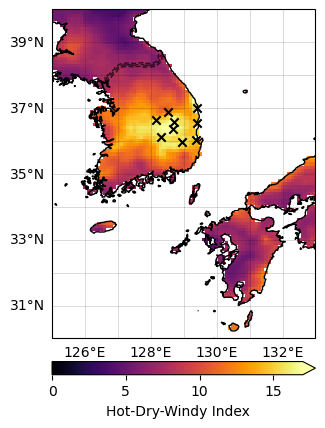

In [19]:
fig, axs = plt.subplots(ncols = 1, figsize = (7,6), dpi = 100)
plt.subplots_adjust(wspace = 0.06)

map_ax =  plt.subplot(121, projection = mapproj, extent = (xn,xx,yn,yx))
ev.plot(ax = map_ax, vmin = 0, vmax = 17, cmap = "inferno", cbar_kwargs = {"label" : "Hot-Dry-Windy Index", "location" : "bottom", "pad" : 0.05, "shrink" : 1})
# map_ax.scatter(px_m.longitude, px_m.latitude, color = "k", marker = ".")
# map_ax.scatter(sites.lon, sites.lat, color = "darkred", marker = "x")

map_ax.gridlines(crs = mapproj, linewidth = 0.5, color = 'black', alpha = 0.2, xlocs = range(125,134), ylocs = range(30,42))
map_ax.gridlines(crs = mapproj, linewidth = 0.5, color = 'black', draw_labels = ["left", "bottom"], alpha = 0, xlocs = range(124,134,2), ylocs = range(31,42,2))

map_ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
map_ax.coastlines()
map_ax.set_title("")
map_ax.scatter(df.lon, df.lat, marker = "x", color = "k")

plt.savefig("fig/figA2-3_station-locations.png")
